SVM example: Identifyng Chronic Kidney Disease
----

# Introduction

This notebook walks through an example implementing a Support Vector Machine to tackle a medical classification problem. The data comes from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease), based on research by P. Soundarapandian, L. Jerlin Rubini, and P. Esweran.


## Outline

1. Implementing a linear SVM
1. Applying and tuning the model
1. Introducing non-linearity

## Setup

We will be using both [NumPy](https://numpy.org/doc/stable/index.html) arrays and [pandas](https://pandas.pydata.org/docs/index.html) DataFrames, so we need to import these packages with their standard abbreviations.

In [607]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# global random number generator, with set seed for demonstration purposes
RNG = np.random.default_rng(1111)

# 1. Implementing a Linear SVM

## Theory

Recall that a **Support Vector Machine** seeks to minimize classification errors while maximizing the width of the margin around the decision boundary, in hopes of increasing generalizability. More formally, we have a dataset of $n$ feature vectors $x^{(i)}$ and labels $y^{(i)}\in {-1,1}$. We want to find a set of parameters ($\theta, \theta_0$) that mimimize the cost function:
$$ J(\theta , \theta _0) = \frac{1}{n} \sum _{i=1}^{n} \text {Loss}_ h (y^{(i)} (\theta \cdot x^{(i)} + \theta _0 )) + \frac{\lambda }{2} \mid \mid \theta \mid \mid ^2$$
where
$$\text{Loss}_h(z)=\begin{cases}0 & z \ge 1 \\1-z & z < 1\end{cases}$$
and $\lambda$ is the **regularization parameter**, determining the relative weight given to margin width (i.e. the inverse of the squared norm of $\theta$) and accuracy (i.e. the `Loss` term). Higher $\lambda$ focuses more on regularization by widening the margin.

We estimate the parameters through **Stochastic Gradient Descent (SGD)**. This means we randomly select an observation $i$ and update the parameters as follows:

$$\theta \leftarrow \theta - \eta \nabla _{\theta } \big [\text {Loss}_ h(y^{(i)}(\theta \cdot x^{(i)} + \theta _0) ) + \frac{\lambda }{2}\mid \mid \theta \mid \mid ^2 \big ]$$
where $\nabla$ is the learning rate. This can be a constant or can be adjusted over the training process. We will use the latter, based on the formula:
$$ \eta_{t+1} = \frac {\eta_t}{t^d} $$
where $t$ is the training epoch, $\eta_t$ is the learning rate for the $t$-th epoch, and $d$ is a decay parameter. 

If the case is placed correctly and outside the classification margin by the current parameters (i.e. $y^{(i)}(\theta \cdot x^{(i)} + \theta _0)\ge 1$), the update is based strictly on the regularization term. So, the gradient is $\lambda \theta$.

If there is a positive `Loss` (i.e. $y^{(i)}(\theta \cdot x^{(i)} + \theta _0)<1$), then the gradient is $-y^{(i)}x^{(i)} + \lambda \theta$.

We continue cycling through the data, shuffling after each epoch, until the change in the cost remains below some threshold.

Note that this algorithm only optimizes the parameters $\theta$, and $\theta_0$, while $\lambda$, the initial $\eta$, the learning rate decay parameter, and the convergence threshold are **hyperparameters** that must be set in advance.

NOTE ABOUT THE OFFSET: rather than treating $\theta_0$ as a separate parameter, it is possibe instead to prepend a `1` to every feature vector, so that the SVM trains $\theta$ as a $D+1$ vector, where the first entry is equivalent to $\theta_0$. This is what will be done below.

## Implementation

The cell below implements a linear SVM as a class that mimics the syntax of the popular machine learning package [scikit-learn](https://scikit-learn.org/stable/index.html).
1. The model is first initialized with given (default or custom) hyperparameters. Here those are the regularization paramter `lam` (for $\lambda$), the learning rate `lrate`, the `decay` of the learning rate, and the convergence `threshold`.
1. Then, the model is trained on data using the method `fit(X, y)`, where X contains the features vectors (observations as rows, features as columns) and y contains the labels. The model saves the trained parameters.
1. After that, the model can be used to assign labels to any feature vectors with the method `predict(X)`
1. Finally, `score(X, y)` calculates and returns the share of correctly predicted cases.

The class below also contains three helper functions called by `predict()`:
1. `cost()` calculates the cost function for the entire dataset, needed to check for convergence
1. `loss()` calculates and returns the Loss function for calculating the cost function, as defined above
1. `train_epoch()` runs through the observations in random order one time, updating the parameters accordingly, and returning the resulting cost function.

The `set_params()` and `copy()` methods will be used in hyperparameter tuning, below.

In [608]:
class LinearSVM():
    def __init__(self, lam=0., lrate0=1., decay=0.5, threshold=1e-4) -> None:
        '''
        Initialize the model with the given hyperparameters:
        - `lam`: the regularization parameter lambda
        - `lrate`: the learning rate
        - `threshold`: the convergence threshold
        '''
        self.lam = lam
        self.lrate0 = lrate0
        self.decay = decay
        self.threshold = threshold
        self.theta = None
        self.max_iter = 1000

    def loss(self, Xi, yi):
        '''The Loss function for one observation'''
        if self.theta is None:
            raise ValueError('Cannot calculate loss without initializing theta')

        agreement = yi*(self.theta @ Xi)
        return 0 if agreement >= 1 else 1-agreement
    
    def cost(self, X, y):
        '''Average cost for the whole dataset'''
        loss_sum = 0
        for Xi, yi in zip(X, y):
            loss_sum += self.loss(Xi, yi)
        return loss_sum/len(y) + self.lam/2 * (self.theta@self.theta)
    
    def train_epoch(self, X, y):
        '''Cycles through cases in random order, updating theta. Returns the average cost after every update'''
        order = np.arange(len(y)) 
        RNG.shuffle(order)
        for i in order:
            grad = self.lam * self.theta
            grad -= y[i]*X[i] if self.loss(X[i], y[i]) > 0 else 0
            self.theta -= self._lrate * grad
        return self.cost(X, y)
    
    def fit(self, X, y):
        '''Fits the model to the data (feature vectors X, labels y). To fit with an offset, prepend `1` to every feature vector'''
        # initialize theta and learning rate
        self.theta = np.zeros(X.shape[-1])
        self._lrate = self.lrate0

        last_cost = np.inf
        for i in range(self.max_iter):
            new_cost = self.train_epoch(X, y)
            if np.abs(last_cost - new_cost) < self.threshold:
                break
            else:
                last_cost = new_cost
                self._lrate = self._lrate/(1+i)**self.decay
        else:
            print(f"Maximum of {self.max_iter} reached without convergence")
        return self
    
    def predict(self, X):
        '''Predicts labels for feature vectors X'''
        return sign(X @ self.theta)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y == y_pred)
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def copy(self):
        return LinearSVM(self.lam, self.lrate0, self.decay, self.threshold)


@np.vectorize
def sign(z):
    '''Converts values to labels, i.e. 1 and -1'''
    return 1 if z>=0 else -1

# 2. Applying and Tuning the Model

The data is stored as in the file `ckd_data.csv`, and we can read it into a pandas DataFrame.

The data has 400 rows. However, only the target label (`class`) has a full 400 observations: every feature has at least some missing values.

In [609]:
raw_data = pd.read_csv('ckd_data.csv', index_col=0)
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

## A Naive Model

As a first pass, we can adopt the most conservative approach to the missing values: dropping any row that contained any. This results in 158 valid observations.

In [610]:
raw_data.rbc.replace({'normal':1, 'abnormal':0, np.nan: np.nan})

0      NaN
1      NaN
2      1.0
3      1.0
4      1.0
      ... 
395    1.0
396    1.0
397    1.0
398    1.0
399    1.0
Name: rbc, Length: 400, dtype: float64

In [611]:
data_dropNA = raw_data.dropna()
data_dropNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 3 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     158 non-null    float64
 1   bp      158 non-null    float64
 2   sg      158 non-null    float64
 3   al      158 non-null    float64
 4   su      158 non-null    float64
 5   rbc     158 non-null    object 
 6   pc      158 non-null    object 
 7   pcc     158 non-null    object 
 8   ba      158 non-null    object 
 9   bgr     158 non-null    float64
 10  bu      158 non-null    float64
 11  sc      158 non-null    float64
 12  sod     158 non-null    float64
 13  pot     158 non-null    float64
 14  hemo    158 non-null    float64
 15  pcv     158 non-null    float64
 16  wbcc    158 non-null    float64
 17  rbcc    158 non-null    float64
 18  htn     158 non-null    object 
 19  dm      158 non-null    object 
 20  cad     158 non-null    object 
 21  appet   158 non-null    object 
 22  pe

Next, we need to convert the non-numeric columns (dtype object above) into a numeric format. As shown below, tt turns out that each of these features represent binary categories. So, we can easily use binary encoding: replacing the categorical feature with that is 1 if the case falls within one category, otherwise 0.

In [612]:
print(data_dropNA.select_dtypes('object').apply(pd.unique).T)

                0           1
rbc        normal    abnormal
pc       abnormal      normal
pcc       present  notpresent
ba     notpresent     present
htn           yes          no
dm             no         yes
cad            no         yes
appet        poor        good
pe            yes          no
ane           yes          no
class         ckd      notckd


In addition, if we look at summary statistics for the numeric features, we notice that they have very different scales. This repreesents a potential problem because the regularization in SVM is based on the *squared norm* of the parameter vector: if different features have different scales, their weights will contribute unevenly to the squared norm.

This can be solved by rescaling the features. Here, we will use standardization, which centers the values of each feature around the mean and rescales by the standard deviation. Again following Scikit-Learn's syntax, the class below defines the class with two key methods: `fit`, which calculates and saves the rescaling factors and `transform` which applies them. One important point to note: since the transformation is based on information derived from the observations, the mean and standard deviation used must be those of the *training* data, even for the *testing* data set. In practice, this is accomplished by only fitting the transformer class once, on the training data.

In [613]:
print(data_dropNA.describe())

              age          bp          sg          al          su         bgr  \
count  158.000000  158.000000  158.000000  158.000000  158.000000  158.000000   
mean    49.563291   74.050633    1.019873    0.797468    0.253165  131.341772   
std     15.512244   11.175381    0.005499    1.413130    0.813397   64.939832   
min      6.000000   50.000000    1.005000    0.000000    0.000000   70.000000   
25%     39.250000   60.000000    1.020000    0.000000    0.000000   97.000000   
50%     50.500000   80.000000    1.020000    0.000000    0.000000  115.500000   
75%     60.000000   80.000000    1.025000    1.000000    0.000000  131.750000   
max     83.000000  110.000000    1.025000    4.000000    5.000000  490.000000   

               bu          sc         sod         pot        hemo         pcv  \
count  158.000000  158.000000  158.000000  158.000000  158.000000  158.000000   
mean    52.575949    2.188608  138.848101    4.636709   13.687342   41.917722   
std     47.395382    3.0776

In [614]:
class StandardScaler():
    def __init__(self) -> None:
        self.means = None
        self.stds = None

    def fit(self, X, y=None):
        nonmissing = ~np.isnan(X)
        self.means = np.mean(X, axis=0, keepdims=True, where=nonmissing)
        self.stds = np.std(X, axis=0, keepdims=True, where=nonmissing)
        self.stds = np.where(self.stds==0, 1, self.stds)
        return self

    def transform(self, X, y=None):
        if self.means is None or self.stds is None:
            raise ValueError('Transformer has not been fit')
        transformed_X = X.copy()
        transformed_X = (transformed_X - self.means) / self.stds
        transformed_X[np.isnan(transformed_X)] = 0
        return transformed_X

The next cell carries out the needed transformations.

First, we dummy encode the categorical features, setting the mode for each column as 0.

For the target label, we need to recode for the SVM algorithm: the positive label $+1$ applies to patients with chronic kidney disease, and the negative label $-1$ to those who do not.

Finally, while the single pandas DataFrame is convenient to exploring the data, for training the model we can split it into feature vectors (X) and labels (y). We also add a 1 to each feature vector to act as an offset.

In [615]:
def prepare_data(df: pd.DataFrame, offset=True):
    '''Encodes categorical data numerically and returns separate feature vectors and labels'''
    df_copy = df.copy()
    if offset:
        df_copy['offset'] = 1
    y = np.where(df_copy['class'] == 'ckd', 1., -1.)
    df_copy.drop(columns='class', inplace=True)
    for col in df_copy.select_dtypes('object').columns:
        mode_val = df_copy[col].mode()[0]
        missing = df_copy[col].isna()
        df_copy[col+mode_val] = np.where(df_copy[col]==mode_val, 0, 1)
        df_copy.loc[missing, col+mode_val] = np.nan
        df_copy.drop(columns=col, inplace=True)
    X = df_copy.to_numpy()
    return X, y


In [616]:
X, y = prepare_data(data_dropNA)

We are not yet ready to train the model, however. We need to split our data into training and test sets. The training data is used to train the model, while the test data is used to assess its generalizable performance. We will set aside $\frac{1}{4}$ of the latter as the test data. This is done randomly, with one adjustment: we want to preserve the rough balance of positively and negatively labeled cases in the training and testing data.

We thus will end up with 4 numpy arrays: `X_train`, `X_test`, `y_train`, `y_test`.

In [617]:
def train_test_split(X: np.ndarray, y:np.ndarray, train_size:float):
    '''Randomly splits arrays into training and test sets, stratifying on the values of `y`'''
    positive_indices = np.flatnonzero(y == 1)
    RNG.shuffle(positive_indices)
    n_train_positive = int(train_size * len(positive_indices))

    negative_indices = np.flatnonzero(y == -1)
    RNG.shuffle(negative_indices)
    n_train_negative = int(train_size * len(negative_indices))

    train_indices = np.concatenate(
        [
            positive_indices[:n_train_positive], 
            negative_indices[:n_train_negative]
        ], 
        axis=None)
    test_indices = np.concatenate(
        [
            positive_indices[n_train_positive:], 
            negative_indices[n_train_negative:]
        ], 
        axis=None)

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


In [618]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.75)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(118, 25) (40, 25) (118,) (40,)


One important thing to note here is that between dropping missing values and splitting the data, we are left with rather few observations.

The cells below fit the model and report on its classification performance in three ways:
1. The share of correctly labeled observations in the training data.
1. The share of correctly labeled observations in the testing data.
1. More fine-grained measures, broken down by label, for the testing data. Precision is the share of predictions that are correct, while recall is the share of members of the class that are correctly labeled by the classifier.

In [619]:
standardizer = StandardScaler()
default_svm = LinearSVM()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
X_test = standardizer.transform(X_test)
default_svm.fit(X_train, y_train)
print('Average training accuracy: ', default_svm.score(X_train, y_train))
print('Average test accuracy: ', default_svm.score(X_test, y_test))

Average training accuracy:  1.0
Average test accuracy:  1.0


In [620]:
y_pred = default_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



There are two things to note here:
1. Because the labels are imbalanced (i.e. there are many more negative than positive cases), the average accuracy does not fully capture the performance across the two labels. In particular, the precision and recall for the positive cases is usually noticeably lower.
1. With so little data, the particular random split between training and testing data substantially impacts the model. This is demonstrated in the next cell, which compares the score for 1000 different iterations of spltting the data and fitting the model.

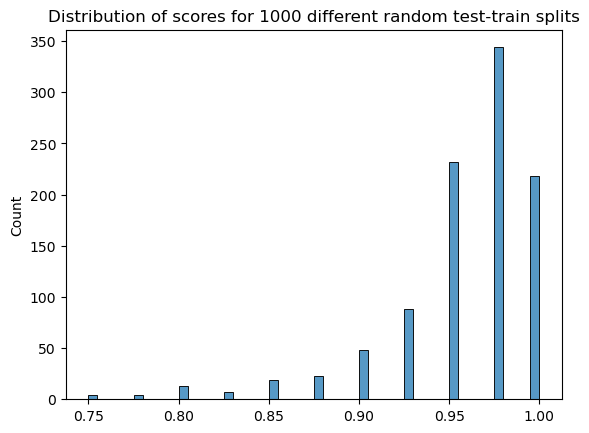

In [604]:
reps = 1000
scores = np.empty(reps)
for i in range(reps):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 0.75)
    default_svm = LinearSVM()
    default_svm.fit(X_train, y_train)
    scores[i] = default_svm.score(X_test, y_test)
sns.histplot(scores)
plt.title(f'Distribution of scores for {reps} different random test-train splits');

So far, we have used only one set of hyperparameters (defined as defaults in the initialization function for the model class above): `lam=1., lrate=1., decay=0.5, threshold=1e-4`. How does the performance of the model vary with these hyperparameters? We can answer this question with **k-fold cross-validation**. That is to say, we split the *training* data into a certain number of equal-sized parts (say, 5), then fit train the model 5 times, each with $\frac {4}{5}$ of the data, and average the performance on the remaining $\frac{1}{5}$. Then, by comparing the results for different sets of hyperparameters, we can tune the model.

 Unfortunately, with only 118 cases in the training data, trying five-fold cross validation would result in training on less than 100 cases and validating on 24. We can't afford to just discard the cases with missing values.

## Imputing Missing Values

We will employ a simple strategy for filling the missing values:
1. For numeric features, replace all missing values with the mean.
1. For categorical features, replace all missing values with the mode.

The cell below does this, taking advantage of the DataFrame method `.select_dtypes()`, where `'object'` corresponds to the categorical data and `'float'` to the numeric.

In [605]:
# cat_fill = raw_data.select_dtypes('object').mode().iloc[0]
# num_fill = raw_data.select_dtypes('float').mean().iloc[0]
# data_filled = raw_data.fillna(cat_fill)
# data_filled.fillna(num_fill, inplace=True)
# data_filled.info()

If we then fit and assess this model using the same procedure as above, we see that the results are somewhat worse. This is not surprising: the cost of including information from the observations with missing values is to introduce some noise from filling in those missing values with the means and modes.

In [624]:
X, y = prepare_data(raw_data, offset=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.75)
standardizer = StandardScaler()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
# X_train[np.isnan(X_train)] = 0
X_test = standardizer.transform(X_test)
# X_test[np.isnan(X_test)] = 0
svm = LinearSVM()
svm.fit(X_train, y_train)
print('Training accuracy: ', svm.score(X_train, y_train))
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

Training accuracy:  0.9297658862876255
              precision    recall  f1-score   support

        -1.0       0.81      1.00      0.89        38
         1.0       1.00      0.86      0.92        63

    accuracy                           0.91       101
   macro avg       0.90      0.93      0.91       101
weighted avg       0.93      0.91      0.91       101



## Hyperparameter Tuning

With this somehwat larger dataset, we can now try to tune the hyperparameters. There are various strategies for hyperparameter turning, including grid search, random search, and Bayesian optimization. Since our model and data are quite small, we can use the first: this entails listing out alternative values for each hyperparameters and then fitting every possible combination of those values.

The next cell defines a class `GridSearchCV` that implements cross-validation by grid-search on a given set of hyperparameters. It mimics the [class of the same name](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) in the Scikit-Learn package.

On initialization the `GridSearchCV` takes a model instance (`estimator`, which needs `fit`, `predict`, and `score` methods) and a dict of parameters to search (`param_grid`). In the parameter grid dictionary, the keys are the parameters names for the model and the values are lists containing the alternative values.

After carrying out the grid search with the `fit()` method, the object saves three attributes:
1. The full `results` as a DataFrame
1. The set of parameters that results in the highest mean score in cross validation (`best_params`)
1. The model refit with all of the training data using the best-performing parameters (`best_estimator`) 

In [625]:
class GridSearchCV():
    def __init__(self, estimator, param_grid:dict, cv=5) -> None:
        self.base_estimator  = estimator.copy()
        self.param_grid = param_grid
        self.cv = cv

    def fit(self, X, y):
        '''Performs grid search cross-validation with the given data'''
        # partition the data
        partitions = self.make_partition(len(y))

        # initialize results
        results = {
            'params': [],
            'mean_score': []
        }
        results.update({
            f'score{i+1}': [] for i in range(self.cv)
        })
        results.update({
            f'param_{param}':[] for param in self.param_grid
        })

        # loop through each parameter set, fitting 5 times and saving scores
        count = 0
        for param_dict in self.iter_params():
            results['params'].append(param_dict)
            for param, value in param_dict.items():
                results[f'param_{param}'].append(value)
            model = self.base_estimator.copy()
            model.set_params(**param_dict)
            total_score = 0
            for i, (train_set, validation_set) in enumerate(partitions):
                model.fit(X[train_set], y[train_set])
                score = model.score(X[validation_set], y[validation_set])
                results[f'score{i+1}'].append(score)
                total_score += score
            results['mean_score'].append(total_score/self.cv)
            count+=1
            # print(count, end=',')
        # save results as a DataFrame
        self.results = pd.DataFrame(results)
        # save best-performing paramets and fit estimator on it with all training data
        self.best_params = self.results.sort_values('mean_score', ascending=False).loc[0, 'params']
        self.best_estimator = self.base_estimator.copy().set_params(**self.best_params).fit(X, y)
        
        return self
    
    def make_partition(self, length):
        '''An iterator that returns training and validation indices for k-fold cross validation'''
        indices = np.arange(length)
        RNG.shuffle(indices)
        step = length // self.cv
        start_points = [step*i for i in range(self.cv)]
        end_points = [step*i for i in range(1, self.cv+1)]
        partitions = []
        for start, end in zip(start_points, end_points):
            partitions.append((np.concatenate([indices[:start], indices[end:]]), indices[start:end]))
        return partitions
    
    def iter_params(self):
        '''Yields every combination of parameters from the parameter dict'''
        grid = [{}]
        for param_name, param_list in self.param_grid.items():
            old_grid = grid
            grid = []
            for val in param_list:
                grid_part = [param_dict.copy() for param_dict in old_grid]
                for param_dict in grid_part:
                    param_dict.update({param_name:val})
                grid += grid_part
        for param_dict in grid:
            yield param_dict


Now we can perform the search. The next cell first defines the grid (actually two alternatives: the small one should finish in less than a minute, while the larger one might take several minutes). Then it initialize the grid search class and calls its `fit` method and printing out a clean version of the top results.

Note that cross-validation is a prime target for parallelization: using the multiple processing cores of a modern computer will cut down the computing time considerably, even on consumer hardware. The Scikit-learn package implements parallelization as an option wherever possible.

In [626]:
param_dict_small = {
    'lam': [0.01, 0.1, 0.5, 1],
    'lrate0': [0.1, 0.5, 1],
    'decay': [0.01, 0.1, 0.5, 1]
}

param_dict_lam = {
    'lam': [0.01, 0.1, 0.5, 1, 5]
}

param_dict_large = {
    'lam': [10.**i for i in range(-3, 3)],
    'lrate0': [10.**i for i in range(-3, 3)],
    'decay': [10.**i for i in range(-3, 3)]
}

searcher = GridSearchCV(LinearSVM(), param_dict_small)
searcher.fit(X_train, y_train)
top_results = (
    searcher.results
        .drop(columns=['params']+[f'score{i+1}' for i in range (5)])
        .sort_values('mean_score', ascending=False)
        .head(10)
)
print(top_results)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,    mean_score  param_lam  param_lrate0  param_decay
9     0.901695       0.10           1.0         0.01
37    0.901695       0.10           0.1         1.00
17    0.898305       0.10           0.5         0.10
13    0.898305       0.10           0.1         0.10
5     0.898305       0.10           0.5         0.01
25    0.894915       0.10           0.1         0.50
32    0.891525       0.01           1.0         0.50
45    0.891525       0.10           1.0         1.00
29    0.891525       0.10           0.5         0.50
1     0.891525       0.10           0.1         0.01


One thing to observe about the results here is that the ideal hyperparameters depend on the values of the other hyperparameters. This is illustrated in the plots below. 

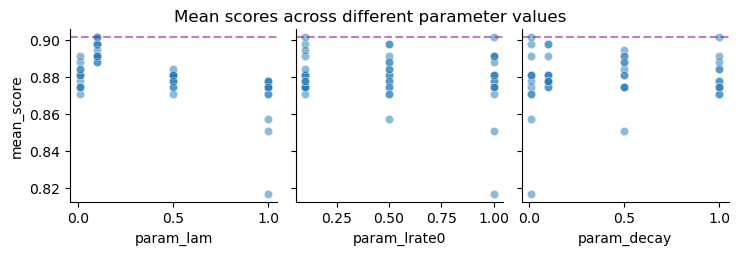

In [627]:
grid = sns.pairplot(searcher.results, x_vars=['param_lam', 'param_lrate0', 'param_decay'], y_vars=['mean_score'], diag_kind=None, plot_kws={'alpha':0.5})
for ax in grid.figure.axes:
    ax.axhline(top_results.mean_score.iloc[0], color='purple', linestyle='--', alpha=0.5)
grid.figure.subplots_adjust(top=.9)
grid.figure.suptitle('Mean scores across different parameter values');

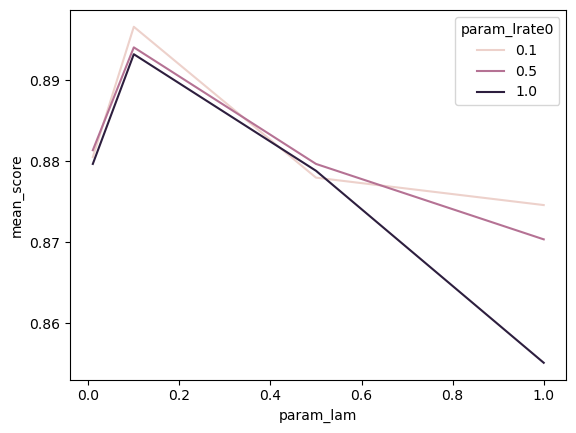

In [628]:
sns.lineplot(searcher.results, y='mean_score', x='param_lam', hue='param_lrate0', errorbar=None);

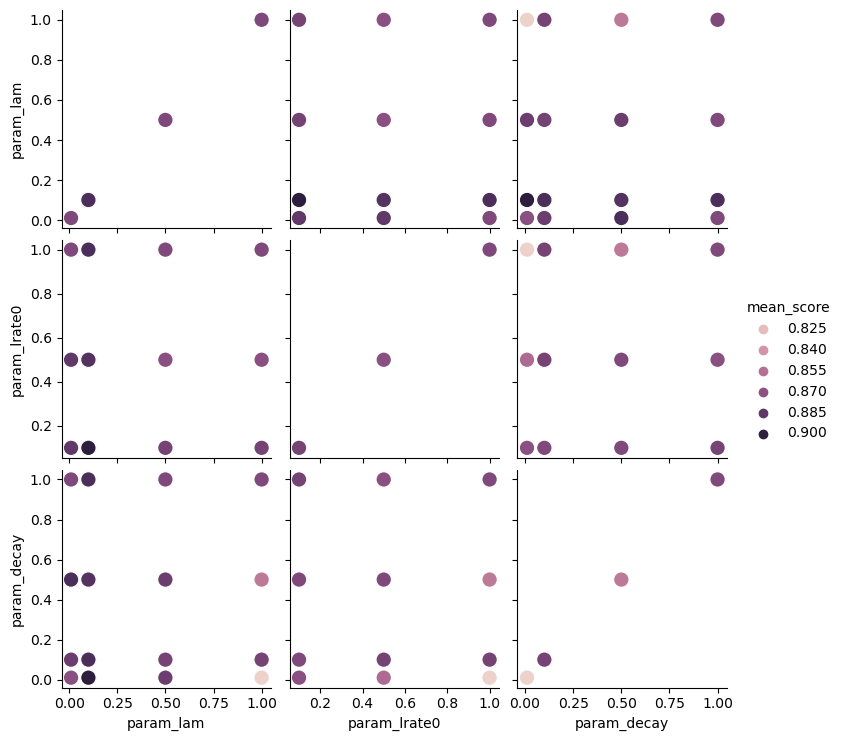

In [629]:
grid = sns.pairplot(searcher.results, vars=['param_lam', 'param_lrate0', 'param_decay'], hue='mean_score', diag_kind=None, plot_kws={'s':125});

In [630]:
print('Training accuracy: ', searcher.best_estimator.score(X_train, y_train))
y_pred = searcher.best_estimator.predict(X_test)
print(classification_report(y_test, y_pred))

Training accuracy:  0.9264214046822743
              precision    recall  f1-score   support

        -1.0       0.76      1.00      0.86        38
         1.0       1.00      0.81      0.89        63

    accuracy                           0.88       101
   macro avg       0.88      0.90      0.88       101
weighted avg       0.91      0.88      0.88       101

